# Reading gds files 

In [1]:
from Libraries_Functions import np, plt, unp, wmean, ur, umean, os, pd, calculate_stage_info, ufloat,convert_uncertainties, convert_uncertainty_columns, calculate_stage_info_all,\
calculate_centroid, A, V, ur, umean, wmean, calculate_stage_info_base, calculate_stage_info, calculate_total_info, convert_uncertainties,convert_uncertainty_columns, interpolate, stats,\
patches, Polygon, Axes3D, PercentFormatter, MultipleLocator, FuncFormatter, math, ransac, uncertainties, unp, EllipseModel, widgets, sns, mpc, mpld3, ufloat_fromstr, BlendedGenericTransform,\
Ellipse, widgets, sns, Filter_outliers
from sklearn.linear_model import LinearRegression ; from sklearn.linear_model import RANSACRegressor
pd.set_option('future.no_silent_downcasting', True)


Number of rows of data in LCC17:  603731

Index(['Stage Number', 'Time since start of test (s)',
       'Time since start of stage (s)', 'Radial Pressure (kPa)',
       'Radial Volume (mm³)', 'Back Pressure (kPa)', 'Back Volume (mm³)',
       'Load Cell (kN)', 'Pore Pressure (kPa)', 'Axial Displacement (mm)',
       'L/C Pressure (kPa)', 'L/C Volume (mm³)', 'Local Axial 1 (mm)',
       'Local Axial 2 (mm)', 'Local Radial (mm)', 'Base Pressure (kPa)',
       'Base Volume (mm³)', 'Back Differential Pressure (kPa)',
       'Axial Displacement 2 (mm)', 'Pore Air Pressure (kPa)',
       'Pore Air Volume (mm³)', 'Atmospheric Pressure (kPa)',
       'Temperature (°C)', 'Mid Plane PWP (kPa)',
       'Back to Cell Differential (kPa)', 'Total Volume Change (mm³)',
       'Undefined Tx 1', 'Undefined Tx 2', 'Undefined Tx 3',
       'Axial Force (kN)', 'Axial Strain (%)', 'Av Diameter Change (mm)',
       'Radial Strain (%)', 'Axial Stress (kPa)', 'Eff. Axial Stress (kPa)',
       'Eff. Radial St

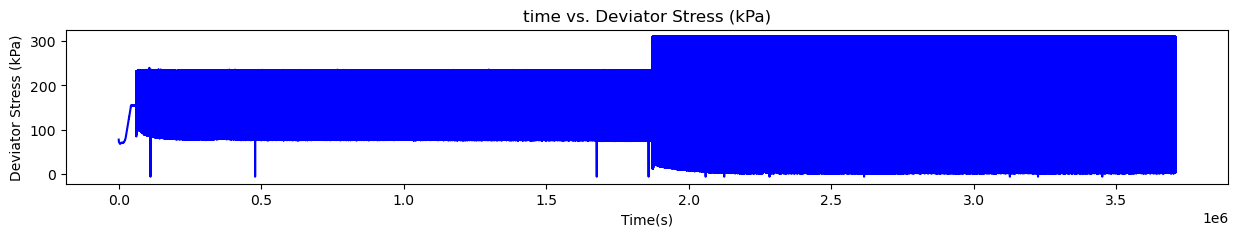

In [2]:
"""Read gds files, skipping the first 28-30 rows and setting the 31st row as the header"""

#current_directory = os.path.dirname(os.path.abspath(__file__))
Path_LCC17 = os.path.join(os.getcwd(), 'gds_files', 'LCC17.gds')
df_LCC17 = pd.read_csv(Path_LCC17, header=29, encoding='latin1')

print()
print("Number of rows of data in LCC17: ", len(df_LCC17))
print()
print(df_LCC17.columns)

plt.figure(figsize=(15, 2)) 
plt.plot(df_LCC17['Time since start of test (s)'], df_LCC17['Deviator Stress (kPa)'], color='b')        # Deviator Stress (kPa)
plt.xlabel("Time(s)")
plt.ylabel("Deviator Stress (kPa)")
plt.title('time vs. Deviator Stress (kPa)')
plt.show()

# Propogation error

In [3]:

""" The peak deviatoric stress (qf ) which is taken from monotonic tests, in our study the value is 
no available, so the value is taken from other research which search the same soil and site ((Wong et al., 2023, p. 7)"""

qf_LCC = np.mean([2.37, 2.53, 1.03, 1.34, 1.92, 2.56]) *1000   ## Unconfined compressive strength 
Su_LCC = qf_LCC / 2


""" The ingiven Data of the sample and Propogation error in Stress, Strain, pwp and deviator stress
"""
## Poisson's ratio
v = 0.2  
#the Uncertainties in the measurements
Ru_d_G = 0.0002      #    Relative Uncertainty in Global displacement sensor
Ru_d_L = 0.00105     #    Relative Uncertainty in Local displacement sensor 
Ru_l = 0.00          #    Relative Uncertainty in axial loading sensor 
v_error = 0.018      # mm Relative Uncertainty in vernier caliper 
Ru_c3 = 0.0086       #    Relative Uncertainty in cell pressure  
Ru_w = 0.0035        #    Relative Uncertainty in pore pressure  

#######
H0_LCC17 = 100.98   # mm  initial height
Lg_LCC17 = 48.57  # mm gauge length 
D0_LCC17 = 47.82 # mm  initial diameter 
A0_LCC17 = A(D0_LCC17)     # m^2
V0_LCC17 = V(A0_LCC17, Lg_LCC17)   # m^3



d_error_LCC = (50-45) / 2 # mm
Ru_A_LCC17 = (2 * d_error_LCC)/(D0_LCC17)                                           #  Relative Uncertainty in Area
Ru_H_G_LCC17 = (v_error/H0_LCC17)                                                #  Relative Uncertainty in change of the hieght of specimne for global strain. 
Ru_H_L_LCC17 = (v_error/Lg_LCC17)                                                #  Relative Uncertainty in change of the hieght of specimne for local strain.   
Ru_strain_G_LCC17 = np.sqrt(((Ru_d_G)**2) + ((Ru_H_G_LCC17)**2))                 #  Relative Uncertainty in Global strain
Ru_strain_L_LCC17 = np.sqrt(((Ru_d_L)**2) + ((Ru_H_L_LCC17)**2))                 #  Relative Uncertainty in Local strain
Ru_stress_LCC17 = np.sqrt(((Ru_l)**2) + ((Ru_A_LCC17)**2))                       #  Relative Uncertainty in Local stress
Ru_E_G_LCC17 = np.sqrt(((Ru_stress_LCC17)**2) + ((Ru_strain_G_LCC17)**2))                       #  Relative Uncertainty in global E
Ru_E_L_LCC17 = np.sqrt(((Ru_stress_LCC17)**2) + ((Ru_strain_L_LCC17)**2))                       #  Relative Uncertainty in Local E
#Ru_Deviatoric_stress_LCC17 = np.sqrt(((Ru_stress_LCC17)**2) + ((Ru_c3)**2))      # Relative Uncertainty in deviatoric stress



""" New columns of propagation error for stress, strain, eff.stress, deviator stress, radial stress and pwp.
"""
"""LCC17
"""

df_LCC17_P = df_LCC17.copy()

#  local strain and global strain as decimel, not precentage. 
df_LCC17_P['Local Axial Strain']  = df_LCC17_P['Local Axial 2 (mm)'] / Lg_LCC17
df_LCC17_P['Global Axial Strain'] = df_LCC17_P['Axial Strain (%)'] / 100

# Stress uncertainty
df_LCC17_P['Axial Stress & Uncertainty (kPa)'] = df_LCC17_P.apply(lambda row: ufloat(row['Axial Stress (kPa)'], Ru_stress_LCC17 * np.abs(row['Axial Stress (kPa)'])), axis=1)

# Local strain uncertainty
df_LCC17_P['Local Axial Strain & Uncertainty'] = df_LCC17_P.apply(lambda row: ufloat(row['Local Axial Strain'], Ru_strain_L_LCC17 * np.abs(row['Local Axial Strain'])), axis=1)


# Global strain uncertainty
df_LCC17_P['Global Axial Strain & Uncertainty'] = df_LCC17_P.apply(lambda row: ufloat(row['Global Axial Strain'], Ru_strain_G_LCC17 * np.abs(row['Global Axial Strain'])), axis=1)


# Radial pressure uncertainty
df_LCC17_P['Radial Pressure & Uncertainty (kPa)'] = df_LCC17_P.apply(lambda row: ufloat(row['Radial Pressure (kPa)'], Ru_c3 * np.abs(row['Radial Pressure (kPa)'])), axis=1)


# deviatoric uncertainty
df_LCC17_P['Error Deviator Stress (kPa)'] = ((unp.std_devs(df_LCC17_P['Axial Stress & Uncertainty (kPa)']))**2 + (unp.std_devs(df_LCC17_P['Radial Pressure & Uncertainty (kPa)']))**2)**0.5
df_LCC17_P['Deviator Stress & Uncertainty (kPa)'] = df_LCC17_P.apply(lambda row: ufloat(row['Deviator Stress (kPa)'], np.abs(row['Error Deviator Stress (kPa)'])), axis=1)


# pore pressure uncertainty
df_LCC17_P['Pore Pressure & Uncertainty (kPa)'] = df_LCC17_P.apply(lambda row: ufloat(row['Pore Pressure (kPa)'], Ru_w * np.abs(row['Pore Pressure (kPa)'])), axis=1)

# Effective Stress  uncertainty
df_LCC17_P['Eff. Stress & Uncertainty (kPa)']  = ((df_LCC17_P['Axial Stress & Uncertainty (kPa)']- df_LCC17_P['Pore Pressure & Uncertainty (kPa)']) + 2 * (df_LCC17_P['Radial Pressure & Uncertainty (kPa)'] - df_LCC17_P['Pore Pressure & Uncertainty (kPa)'] ))  / 3

# Reorder columns to position them at the end
cols = list(df_LCC17_P.columns)
cols = cols[:-10] + cols[-10:]
df_LCC17_P = df_LCC17_P[cols]


print("The ingiven Data of the sample LCC17:")
print(f"H0 = {H0_LCC17:.2f} mm")
print(f"Lg = {Lg_LCC17:.2f} mm")
print(f"A0 = {A0_LCC17:.6f}  m^2")
print(f"V0 = {V0_LCC17:.9f} m^3")
print(f"v = {v} ")

print(f'relative uncertainty in Axial stress {Ru_stress_LCC17:.5f}')
print(f'relative uncertainty in Global strain{Ru_strain_G_LCC17:.9f}')
print(f'relative uncertainty in Local strain {Ru_strain_L_LCC17:.5f}')
print("Number of rows: ", len(df_LCC17_P))

print(df_LCC17_P.columns)

The ingiven Data of the sample LCC17:
H0 = 100.98 mm
Lg = 48.57 mm
A0 = 0.001796  m^2
V0 = 0.000087232 m^3
v = 0.2 
relative uncertainty in Axial stress 0.10456
relative uncertainty in Global strain0.000267907
relative uncertainty in Local strain 0.00111
Number of rows:  603731
Index(['Stage Number', 'Time since start of test (s)',
       'Time since start of stage (s)', 'Radial Pressure (kPa)',
       'Radial Volume (mm³)', 'Back Pressure (kPa)', 'Back Volume (mm³)',
       'Load Cell (kN)', 'Pore Pressure (kPa)', 'Axial Displacement (mm)',
       'L/C Pressure (kPa)', 'L/C Volume (mm³)', 'Local Axial 1 (mm)',
       'Local Axial 2 (mm)', 'Local Radial (mm)', 'Base Pressure (kPa)',
       'Base Volume (mm³)', 'Back Differential Pressure (kPa)',
       'Axial Displacement 2 (mm)', 'Pore Air Pressure (kPa)',
       'Pore Air Volume (mm³)', 'Atmospheric Pressure (kPa)',
       'Temperature (°C)', 'Mid Plane PWP (kPa)',
       'Back to Cell Differential (kPa)', 'Total Volume Change (mm³)'

# Cycles in the dataset

In [4]:
# Create a new DataFrame for the range of cyclic loading
# Boundaries index for cyclic loading 
br1 = 1026
br2 = 603708
df_range = df_LCC17_P.iloc[br1:br2].copy()

# Calculate the mean value of the 4th column starting from row 1027
mean_val_LCC17_P = np.mean(df_range.loc[:,'Deviator Stress (kPa)']) 

# Calculate the difference between the mean value.
df_range.loc[:, 'diff'] = df_range.loc[:,'Deviator Stress (kPa)'] - mean_val_LCC17_P

# Find where the difference changes sign (crosses zero)
crossings = np.where(np.diff(np.sign(df_range['diff'])))[0]

# Interpolate to find more accurate crossing points 
#Include the first point if the first points of cyclic points are above the mean value so the first cycle cannot be identified without the including. 
if df_range.iloc[0]['Deviator Stress (kPa)'] > mean_val_LCC17_P:
    crossing_points = [df_range.iloc[0]['Time since start of test (s)']]
else:
    crossing_points = []
crossing_values = []   

for idx in crossings:
    x1, y1 = df_range.iloc[idx]['Time since start of test (s)'], df_range.iloc[idx]['Deviator Stress (kPa)'] 
    x2, y2 = df_range.iloc[idx+1]['Time since start of test (s)'], df_range.iloc[idx+1]['Deviator Stress (kPa)']
    x = x1 - (y1 - mean_val_LCC17_P) * ((x2 - x1) / (y2 - y1))
    crossing_points.append(x)

# Convert crossing_points to a DataFrame
crossing_df_LCC17 = pd.DataFrame(crossing_points, columns=['corresponding_time'])

## Interpolate the values from 'Deviator Stress (kPa)' at the crossing points
crossing_df_LCC17['corresponding_Deviator_Stress'] = np.interp(crossing_points, df_range.loc[:,'Time since start of test (s)'], df_range.loc[:,'Deviator Stress (kPa)'])
crossing_df_LCC17['crossing_points_number'] = range(1, len(crossing_points) + 1)
#crossing_df_LCC17['time_diff_crossing'] = crossing_df_LCC17['corresponding_time'].diff().fillna(0)

crossing_df_LCC17 = crossing_df_LCC17[['crossing_points_number', 'corresponding_time', 'corresponding_Deviator_Stress']]

# Create a new column 'time of the cycle'
crossing_df_LCC17['Cycle time'] = np.nan

# Calculate the time difference between cycle time 
for i in range(0, len(crossing_df_LCC17), 1):
    if i + 1 < len(crossing_df_LCC17):
        time_crossing_diff = crossing_df_LCC17.iloc[i+1]['corresponding_time'] - crossing_df_LCC17.iloc[i]['corresponding_time']
        crossing_df_LCC17.loc[i, 'time_diff_crossing'] = time_crossing_diff

crossing_df_LCC17 = crossing_df_LCC17[['crossing_points_number', 'corresponding_time', 'corresponding_Deviator_Stress', 'time_diff_crossing']]

## Filter the crossing points if there are short intersection between the points

In [5]:
## Filter crossing_df_LCC17 based on the time difference condition
filtered_crossing_df_LCC17 = pd.DataFrame(columns=['crossing_points_number', 'corresponding_time', 'corresponding_Deviator_Stress', 'time_diff_crossing', 'Cycle time' ])

time_threshold = 20  # Set the time threshold in seconds for the diff time in the short intersection

for i in range(len(crossing_df_LCC17)):
    if crossing_df_LCC17.iloc[i]['time_diff_crossing'] >= time_threshold:
         filtered_crossing_df_LCC17 = pd.concat([filtered_crossing_df_LCC17, pd.DataFrame(crossing_df_LCC17.iloc[i, :]).T], ignore_index=True)

# Reset the index and crossing_points_number column
filtered_crossing_df_LCC17 = filtered_crossing_df_LCC17.reset_index(drop=True)
filtered_crossing_df_LCC17['crossing_points_number'] = range(1, len(filtered_crossing_df_LCC17) + 1)


# Calculate the time difference between cycle time 
for i in range(0, len(filtered_crossing_df_LCC17), 2):
    if i + 2 < len(filtered_crossing_df_LCC17):
        time_cycle_diff = filtered_crossing_df_LCC17.iloc[i+2]['corresponding_time'] - filtered_crossing_df_LCC17.iloc[i]['corresponding_time']
        filtered_crossing_df_LCC17.loc[i, 'Cycle time'] = time_cycle_diff




""" The cycles below identified from the last code which these cycles cannot be fitted as ellipse"""
pairs_to_remove = []

# Divide the data into cycles and produce a new dataframe "df_cycles_LCC17" that has columns for cycle nr
pairs_LCC17 = [(filtered_crossing_df_LCC17.loc[i,'corresponding_time'], filtered_crossing_df_LCC17.loc[i+2,'corresponding_time']) for i in range(0, len(filtered_crossing_df_LCC17)-2, 2)]

# Filter pairs with at least 5 indices and exclude pairs in pairs_to_remove
filtered_pairs_LCC17 = []
for i, (start_index, end_index) in enumerate(pairs_LCC17):
  cycle_indices = df_LCC17_P[df_LCC17_P['Time since start of test (s)'].between(start_index, end_index)].index
  if len(cycle_indices) >= 4 and i not in pairs_to_remove:  # Check for both conditions
    filtered_pairs_LCC17.append((start_index, end_index))

cycles_LCC17 = []
for start_index, end_index in filtered_pairs_LCC17:
    cycle_indices = df_LCC17_P[(df_LCC17_P['Time since start of test (s)'] >= start_index) & (df_LCC17_P['Time since start of test (s)'] <= end_index)].index
    time_cycle_index = filtered_crossing_df_LCC17[filtered_crossing_df_LCC17['corresponding_time'] == start_index].index[0]
    time_cycle_value = filtered_crossing_df_LCC17.loc[time_cycle_index, 'Cycle time']
    df_LCC17_P.loc[cycle_indices, 'Cycle time'] = time_cycle_value
    df_LCC17_P.loc[cycle_indices, 'Cycle nr'] = len(cycles_LCC17) + 1
    cycle_LCC17 = df_LCC17_P[df_LCC17_P['Cycle nr'] == len(cycles_LCC17) + 1]
    cycles_LCC17.append(cycle_LCC17)

# Reorder columns in df_LCC17_P
cols = df_LCC17_P.columns.tolist()
cols.insert(1, cols.pop(cols.index('Cycle nr')))
cols.append(cols.pop(cols.index('Cycle time')))
df_LCC17_P = df_LCC17_P[cols]

# Reorder columns in cycles_LCC17
for i, cycle in enumerate(cycles_LCC17):
    cols = cycle.columns.tolist()
    cols.insert(1, cols.pop(cols.index('Cycle nr')))
    cols.append(cols.pop(cols.index('Cycle time')))
    cycles_LCC17[i] = cycle[cols]

df_LCC17_new = df_LCC17_P.copy()

""" Export this DataFrame to a CSV file """
Path_df_LCC17_new = os.path.join('Outputs_csv', 'df_LCC17_new.csv')
df_LCC17_new.to_csv(Path_df_LCC17_new, index=False)


C:\Users\local_zakial\Temp\ipykernel_7524\210420252.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  filtered_crossing_df_LCC17 = pd.concat([filtered_crossing_df_LCC17, pd.DataFrame(crossing_df_LCC17.iloc[i, :]).T], ignore_index=True)


In [37]:
time_cross = filtered_crossing_df_LCC17.loc[0]['corresponding_time']
time_cross

61504.06231521243

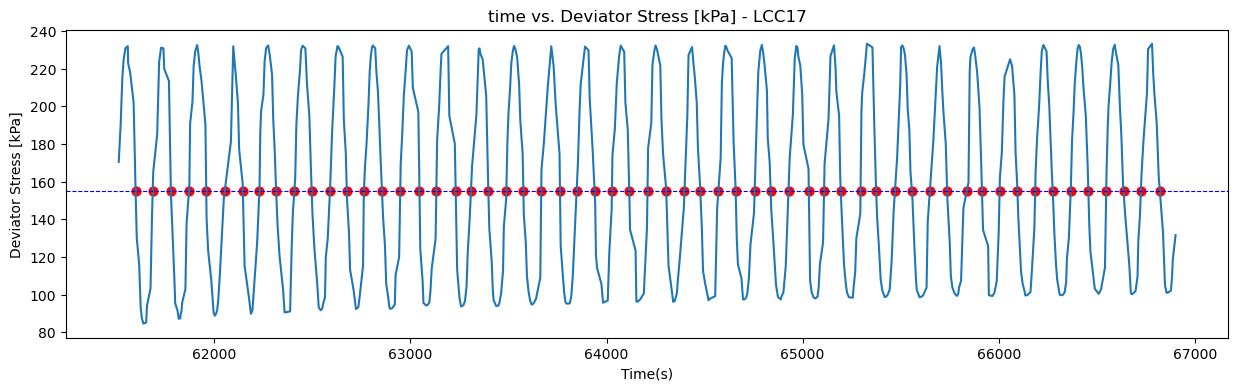

In [76]:
###### Plot the data for several loops ################################# 236899
X1 = 0  # 10000
X2 = 30 # 10030
C1 = 1
C2 = 60
time_values1 = []
stress_values1 = []

stress_indices = list(range(X1, X2))
cross_indices = list(range(C1, C2))

plt.figure(figsize=(15, 4))

for i in stress_indices:
    if i < len(cycles_LCC17):
        time_values = cycles_LCC17[i]['Time since start of test (s)']
        stress_values = cycles_LCC17[i]['Deviator Stress (kPa)']
        time_values1.extend(time_values)
        stress_values1.extend(stress_values)

for j in cross_indices:
    if j < len(filtered_crossing_df_LCC17):
        time_cross = filtered_crossing_df_LCC17.loc[j]['corresponding_time']
        stress_cross = filtered_crossing_df_LCC17.loc[j]['corresponding_Deviator_Stress']
        plt.scatter(time_cross, stress_cross, s=40, c='r', marker='o')

plt.plot(time_values1, stress_values1)
plt.xlabel("Time(s)")
plt.ylabel('Deviator Stress [kPa]')
plt.title('time vs. Deviator Stress [kPa] - LCC17')
plt.axhline(y=mean_val_LCC17_P, color='b', linestyle='--', linewidth='0.8', label='Mean Value')
plt.show()

In [7]:
print(f'The number of crossing points before the filtering: {len(crossing_df_LCC17)} point')
print(f'The number of crossing points before the filtering : {len(filtered_crossing_df_LCC17)} points')

print(f'The number of cycles: {len(cycles_LCC17)} cycles')
print(f'The number of data rows: {len(df_LCC17_new)} cycles')

df_LCC17_new.columns
df_LCC17_new[8947:8987]
cycles_LCC17[0]  

The number of crossing points before the filtering: 40525 point
The number of crossing points before the filtering : 40519 points
The number of cycles: 20259 cycles
The number of data rows: 603731 cycles


,Stage Number,Cycle nr,Time since start of test (s),Time since start of stage (s),Radial Pressure (kPa),Radial Volume (mm³),Back Pressure (kPa),Back Volume (mm³),Load Cell (kN),Pore Pressure (kPa),...,Global Axial Strain,Axial Stress & Uncertainty (kPa),Local Axial Strain & Uncertainty,Global Axial Strain & Uncertainty,Radial Pressure & Uncertainty (kPa),Error Deviator Stress (kPa),Deviator Stress & Uncertainty (kPa),Pore Pressure & Uncertainty (kPa),Eff. Stress & Uncertainty (kPa),Cycle time
1028,2,1.0,61512,14,260,19215,100.0,76,0.3065,-7.949,...,0.000693,(4.3+/-0.5)e+02,0.015668+/-0.000017,0.00069300+/-0.00000019,260.0+/-2.2,45.065575,(1.7+/-0.5)e+02,-7.949+/-0.028,325+/-15,181.136228
1029,2,1.0,61522,24,273,19170,100.2,76,0.3430,-7.799,...,0.000891,(4.6+/-0.5)e+02,0.015689+/-0.000017,0.00089100+/-0.00000024,273.0+/-2.3,48.546423,(1.9+/-0.5)e+02,-7.799+/-0.027,344+/-16,181.136228
1030,2,1.0,61530,32,288,19120,100.0,76,0.3857,-7.649,...,0.001089,(5.0+/-0.5)e+02,0.015709+/-0.000017,0.00108900+/-0.00000029,288.0+/-2.5,52.589996,(2.1+/-0.5)e+02,-7.649+/-0.027,367+/-18,181.136228
1031,2,1.0,61536,38,295,19096,100.1,76,0.4028,-7.499,...,0.001089,(5.2+/-0.5)e+02,0.015730+/-0.000018,0.00108900+/-0.00000029,295.0+/-2.5,54.317363,(2.2+/-0.5)e+02,-7.499+/-0.026,377+/-18,181.136228
1032,2,1.0,61546,48,299,19079,99.9,76,0.4154,-7.499,...,0.001188,(5.3+/-0.6)e+02,0.015730+/-0.000018,0.00118800+/-0.00000032,299.0+/-2.6,55.469002,(2.3+/-0.6)e+02,-7.499+/-0.026,383+/-19,181.136228
1033,2,1.0,61558,60,299,19074,99.9,77,0.4173,-7.499,...,0.001089,(5.3+/-0.6)e+02,0.015730+/-0.000018,0.00108900+/-0.00000029,299.0+/-2.6,55.578702,(2.3+/-0.6)e+02,-7.499+/-0.026,384+/-19,181.136228
1034,2,1.0,61560,62,294,19090,100.0,77,0.4010,-7.649,...,0.001089,(5.2+/-0.5)e+02,0.015730+/-0.000018,0.00108900+/-0.00000029,294.0+/-2.5,54.107622,(2.2+/-0.5)e+02,-7.649+/-0.027,376+/-18,181.136228
1035,2,1.0,61570,72,290,19100,100.2,77,0.3923,-7.649,...,0.001089,(5.1+/-0.5)e+02,0.015730+/-0.000018,0.00108900+/-0.00000029,290.0+/-2.5,53.182768,(2.2+/-0.5)e+02,-7.649+/-0.027,370+/-18,181.136228
1036,2,1.0,61588,90,279,19132,99.9,77,0.3633,-7.799,...,0.001089,(4.8+/-0.5)e+02,0.015709+/-0.000017,0.00108900+/-0.00000029,279.0+/-2.4,50.344767,(2.0+/-0.5)e+02,-7.799+/-0.027,354+/-17,181.136228
1037,2,1.0,61598,100,248,19248,100.1,77,0.2775,-8.249,...,0.000693,(4.0+/-0.4)e+02,0.015668+/-0.000017,0.00069300+/-0.00000019,248.0+/-2.1,42.121357,(1.5+/-0.4)e+02,-8.249+/-0.029,308+/-14,181.136228


# Stage info 

In [8]:
df = df_LCC17_new[:].reset_index()
cycles_data = cycles_LCC17
name =  'LCC17'
P0q0_stage_nr = 2
qm_stage_nr =  2
qf = qf_LCC
Su = Su_LCC
Stage_info_all_LCC17 = calculate_stage_info_all(df, cycles_data, name, P0q0_stage_nr, qm_stage_nr, qf, Su)
Stage_info_all_LCC17

,Sample type,Stage Number,Start index,End index,Rows nr,Start time,End time,Test duration(d),Cyclic loading duration(d),Cycles nr,...,q_p,q_m,q_min,q_max,q_avg,qcyc,qcyc/p0,CSR,qc/2Su,qm/2Su
0,LCC17,1,0,1025,1026,0,61492,0.711713,0.000000,0,...,0,0,0,0,0,0.0,0,0,0,0
1,LCC17,2,1026,216770,215745,61498,1872958,20.965972,20.965972,10064,...,0.0+/-0,(1.6+/-0.4)e+02,78.28+/-0.29,233.1+/-0.6,155.60+/-0.10,77.41+/-0.31,0.250+/-0.011,0.01976+/-0.00008,0.03953+/-0.00016,0.079+/-0.022
2,LCC17,3,216771,603730,386960,1872964,3708268,21.241944,21.241944,10196,...,0.0+/-0,(1.6+/-0.4)e+02,4.82+/-0.16,310.0+/-0.7,154.72+/-0.08,152.57+/-0.35,0.493+/-0.023,0.03895+/-0.00009,0.07791+/-0.00018,0.079+/-0.022


In [9]:
line_ranges = [(2, 2), (3, 3)]  # The range of Stage loading for each stage number. 
Stage_info_LCC17 = calculate_stage_info(df, cycles_data, name, P0q0_stage_nr, qm_stage_nr, qf, Su, line_ranges)
# Export this DataFrame to a CSV file
Path_Stage_info_LCC17 = os.path.join('Outputs_csv', 'Stage_info_LCC17.csv')
Stage_info_LCC17.to_csv(Path_Stage_info_LCC17, index=False)
Stage_info_LCC17

,Sample type,Stage Number,Start index,End index,Rows nr,Star time,End time,Test duration(d),Cyclic loading duration(d),Cycles nr,...,q_m,q_p,q_min,q_max,q_avg,qcyc,qcyc/p0,CSR,qc/2Su,qm/2Su
0,LCC17,1,1026,216770,215745,61498,1872958,42.91963,20.965972,10064,...,(1.6+/-0.4)e+02,0,78.28+/-0.29,233.1+/-0.6,155.60+/-0.10,77.41+/-0.31,0.250+/-0.011,0.01976+/-0.00008,0.03953+/-0.00016,0.079+/-0.022
1,LCC17,2,216771,603730,386960,1872964,3708268,42.91963,21.241944,10196,...,(1.6+/-0.4)e+02,0,4.82+/-0.16,310.0+/-0.7,154.72+/-0.08,152.57+/-0.35,0.493+/-0.023,0.03895+/-0.00009,0.07791+/-0.00018,0.079+/-0.022


# Stress-strain Cycle - Fit Ellispe

## Global cycles

### Single Cycle


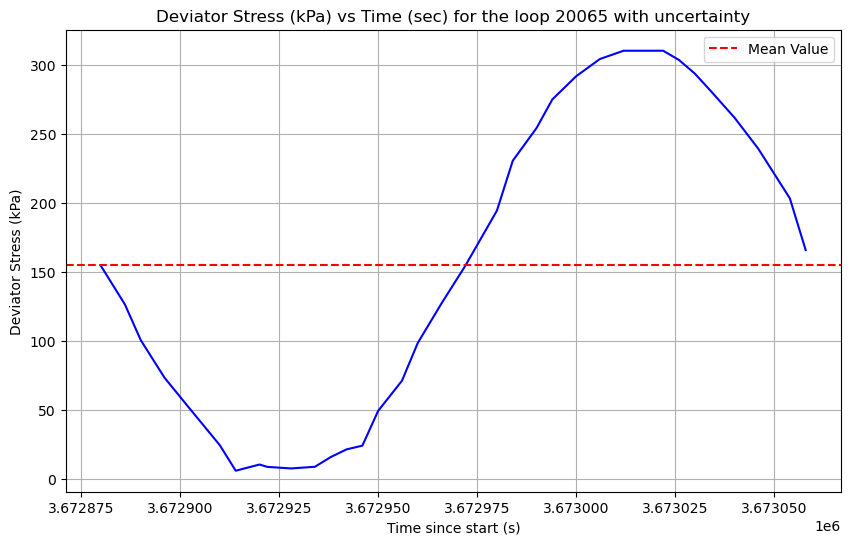

qmax: (3.1+/-0.7)e+02
qmin: 6+/-17
qcyc: (1.5+/-0.4)e+02
pwp_LCC17: -8.074+/-0.005
delta_pwp_LCC17: 0.041+/-0.008


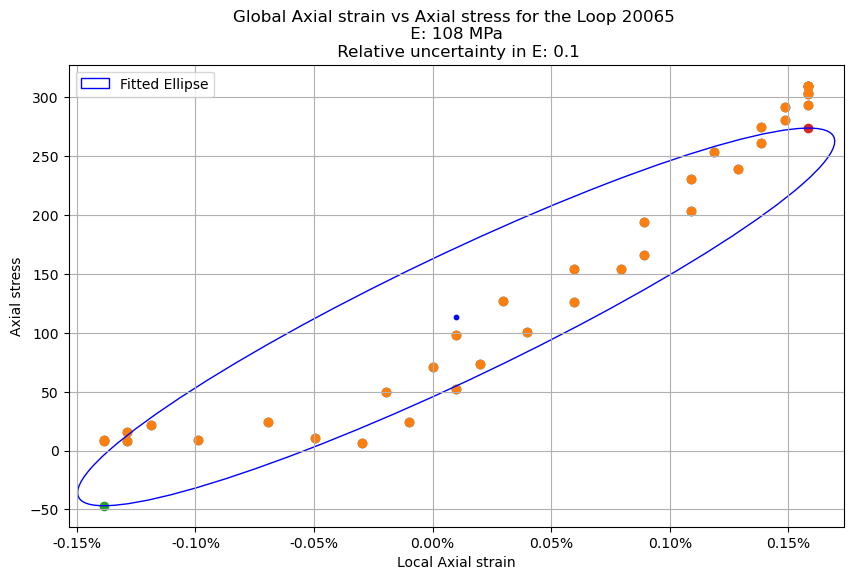

min_x: -0.001386
max_x: 0.0015840000000000001
min_y: -46.85243253228555
max_y: 273.99047070236355

E: 108.02791354701988 MPa
E error: 11.295301982262787 MPa
shear_modulus_mPa: 45.01163064459162

angle 89.99946962060426
prefixed_major_axis_length 320.84291205554905
minor_axis_length 0.001168703191391533
Centriod 0.0099000+/-0.0000027 0.114+/-0.012
width_x 0.0029700000000000004
height_y_MPa 0.3208429032346491

CSR :0.039+/-0.009
qcyc/po :0.49+/-0.12
qcyc/2su :0.078+/-0.018
qm / 2su :0.079+/-0.022

shear_strain :0.0118800+/-0.0000032
shear_strain :0.0118800+/-0.0000032


In [25]:
#The loop number i+1: 
i = 10065 + 10000 - 1
f_b = 100

time = cycles_LCC17[i]['Time since start of test (s)']
deviator_stress = cycles_LCC17[i]['Deviator Stress (kPa)']
yerr = cycles_LCC17[i]['Error Deviator Stress (kPa)']

x_values = cycles_LCC17[i]['Global Axial Strain'].tolist()     ## Axial Strain 
y_values = cycles_LCC17[i]['Deviator Stress (kPa)'].tolist()     ## Axial Stress kPa

plt.figure(figsize=(10, 6))
#plt.errorbar(time, deviator_stress, yerr = yerr, fmt='.', linewidth=2, capsize=6) 
plt.plot(time, cycles_LCC17[i]['Deviator Stress (kPa)'], color='blue')
plt.xlabel("Time since start (s)")
plt.ylabel("Deviator Stress (kPa)")
plt.axhline(mean_val_LCC17_P, color='r', linestyle='--', label='Mean Value')
plt.legend()
plt.title(f'Deviator Stress (kPa) vs Time (sec) for the loop {i+1} with uncertainty')
plt.grid(True)
plt.show()


## the cycle amplitude 
qmax = np.max(cycles_LCC17[i]['Deviator Stress & Uncertainty (kPa)'])
qmin = np.min(cycles_LCC17[i]['Deviator Stress & Uncertainty (kPa)'])
qcyc = (qmax - qmin) / 2

print("qmax:", qmax) 
print("qmin:", qmin) 
print("qcyc:", qcyc) 

pwp_LCC17 =  umean(cycles_LCC17[i]['Pore Pressure & Uncertainty (kPa)'])
delta_pwp_LCC17 = umean(cycles_LCC17[i]['Pore Pressure & Uncertainty (kPa)']) - umean(cycles_LCC17[0]['Pore Pressure & Uncertainty (kPa)'])
print("pwp_LCC17:", pwp_LCC17)
print("delta_pwp_LCC17:", delta_pwp_LCC17)


###############
# Filter the outliers in the cycle
#########################################

x_o, y_o, min_x, max_x, min_y, max_y, Cx_l, Cy_l, angle_in_radians, angle_in_degrees, prefixed_major_axis_length = (
Filter_outliers(x_values, y_values, f_b) )

#########################################
# Plot the fit ellipse   #####################
#########################################

# Fit an ellipse model using RANSAC
model = EllipseModel()
points = np.column_stack((x_o, y_o))
model.estimate(points)
center = model.params[0:2]
center_projection_x = center[0]
center_projection_y = center[1]
major_axis_length = model.params[2] * 2
minor_axis_length = model.params[3] * 2
angle = np.degrees(model.params[4])
prefixed_minor_axis_length = minor_axis_length * (prefixed_major_axis_length / major_axis_length )

## The centriod and lateral values with uncertainty 
Error_C_x = abs(Cx_l * Ru_strain_G_LCC17)                       ####
Error_C_y = abs(Cy_l * Ru_stress_LCC17)                         ####


C_X = ufloat(Cx_l, Error_C_x) * 100  ## △ɛ %
C_Y_MPa = ufloat(Cy_l, Error_C_y) /1000  ## MPa

height_y = abs(max_y - min_y)
height_y_MPa = height_y / 1000     ## MPa
width_x  = abs(max_x - min_x)

E =  height_y_MPa / width_x  ## MPa
E_error = E *  Ru_E_G_LCC17                                                              ####
E_U = ufloat(E, E_error)                                                          

ellipse_area = np.pi * prefixed_major_axis_length * prefixed_minor_axis_length / 4
tri_area = 0.5 * (height_y) * (width_x)
damping_ratio = (1/np.pi) * (ellipse_area/tri_area) 

shear_modulus_mPa = E / (2*(1+v))  ## MPa

shear_strain = (1+v) * C_X  ## %△ϓ = (1+v)△ɛ   Shear strain
shear_stress_mPa = C_Y_MPa / 2    ## △τ = △σ/2   Shear stress

CSR      = qcyc / (2* qf_LCC)
qcyc_po  = qcyc /(Stage_info_LCC17.loc[0]['p_0'])
qcyc_2su = qcyc / (2 * Su_LCC)
qm_2su   = (Stage_info_LCC17.loc[0]['q_m'])/ (2 * Su_LCC)


plt.figure(figsize=(10, 6))            
plt.scatter(x_values, y_values)
plt.scatter(x_o, y_o)
plt.scatter(min_x, min_y)
plt.scatter(max_x, max_y)
plt.scatter(Cx_l, Cy_l, s=10, c='b', marker='o')
ellipse_cstr = Ellipse(xy =(Cx_l, Cy_l), width=prefixed_major_axis_length, height=prefixed_minor_axis_length, angle=angle_in_degrees, edgecolor='b', fill = False, label='Fitted Ellipse')
plt.gca().add_patch(ellipse_cstr)
#plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=100))  # Set max to 100%
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x*100:.2f}%'))  # Format ticks as percentages
plt.xlabel('Local Axial strain')
plt.ylabel('Axial stress')
plt.title(f'Global Axial strain vs Axial stress for the Loop {i+1} \n E: {E:.0f} MPa \n Relative uncertainty in E: {Ru_E_G_LCC17:.1f}')
plt.grid(True)
plt.legend()
plt.show()

print(f'min_x: {min_x}')
print(f'max_x: {max_x}')
print(f'min_y: {min_y}')
print(f'max_y: {max_y}')
print()
print(f'E: {E} MPa')
print(f'E error: {E_error} MPa') 
print(f'shear_modulus_mPa: {shear_modulus_mPa}') 
print()
print(f"angle", angle_in_degrees)
print(f"prefixed_major_axis_length", prefixed_major_axis_length)
print(f"minor_axis_length", prefixed_minor_axis_length)
print(f"Centriod", C_X,C_Y_MPa)
print(f"width_x", width_x)
print(f"height_y_MPa", height_y_MPa)
print()
print(f'CSR :{CSR}')
print(f'qcyc/po :{qcyc_po }')
print(f'qcyc/2su :{qcyc_2su}')
print(f'qm / 2su :{qm_2su  }')
print()
print(f'shear_strain :{shear_strain}')
print(f'shear_strain :{shear_strain }')


### All Cycles

In [24]:
# For each loop, get the start and end times
#plt.figure(figsize=(10, 6))   
f_b = 100
cycle_info_LCC17 = []
for n, loop in enumerate(cycles_LCC17):
  try:
    start_time = loop.iloc[0,2]
    end_time = loop.iloc[-1,2]
        

    x_values = cycles_LCC17[n]['Global Axial Strain'].tolist()     ## Axial Strain 
    y_values = cycles_LCC17[n]['Deviator Stress (kPa)'].tolist()     ## Axial Stress kPa 
    
    ## the cycle amplitude 
    qmax = np.max(cycles_LCC17[n]['Deviator Stress & Uncertainty (kPa)'])
    qmin = np.min(cycles_LCC17[n]['Deviator Stress & Uncertainty (kPa)'])
    qcyc = (qmax - qmin) / 2
    
        
    ## Excess pore water pressure
    pwp =  umean(cycles_LCC17[n]['Pore Pressure & Uncertainty (kPa)'])
    pwp0 = umean(cycles_LCC17[0]['Pore Pressure & Uncertainty (kPa)'])
    delta_pwp = pwp - pwp0
    
    
    ## Loading period T and Frequency of loading f
    Tmax = np.max(cycles_LCC17[n]['Time since start of test (s)'])
    Tmin = np.min(cycles_LCC17[n]['Time since start of test (s)'])  
    T = Tmax - Tmin  
    f = 1 / T
    


    ################################
    # Ellipse calculation    #######
    ################################
    #########################################
        
    ###############
    # Filter the outliers in the cycle
    #########################################
    x_o, y_o, min_x, max_x, min_y, max_y, Cx_l, Cy_l, angle_in_radians, angle_in_degrees, prefixed_major_axis_length = (
    Filter_outliers(x_values, y_values, f_b) )
    
    #########################################
    # Plot the fit ellipse   ################
    #########################################
    
    # Fit an ellipse model using RANSAC
    model = EllipseModel()
    points = np.column_stack((x_o, y_o))
    model.estimate(points)
    center = model.params[0:2]
    center_projection_x = center[0]
    center_projection_y = center[1]
    major_axis_length = model.params[2] * 2
    minor_axis_length = model.params[3] * 2
    angle = np.degrees(model.params[4])
    prefixed_minor_axis_length = minor_axis_length * (prefixed_major_axis_length / major_axis_length )
    
    ## The centriod and lateral values with uncertainty 
    Error_C_x = abs(Cx_l * Ru_strain_G_LCC17)
    Error_C_y = abs(Cy_l * Ru_stress_LCC17)

    C_X = ufloat(Cx_l, Error_C_x) * 100  ## △ɛ %
    C_Y_MPa = ufloat(Cy_l, Error_C_y) /1000  ## MPa

    
    height_y = abs(max_y - min_y)
    height_y_MPa = height_y / 1000     ## MPa
    width_x  = abs(max_x - min_x)
    
    E =  height_y_MPa / width_x  ## MPa
    E_error = E *  Ru_E_G_LCC17                                                              ####
    E_U = ufloat(E, E_error)       
    
    ellipse_area = np.pi * prefixed_major_axis_length * prefixed_minor_axis_length / 4
    tri_area = 0.5 * (height_y) * (width_x)
    damping_ratio = (1/np.pi) * (ellipse_area/tri_area) 
    
    shear_modulus_mPa = E / (2*(1+v))  ## MPa
    
    shear_strain = (1+v) * C_X  ## %△ϓ = (1+v)△ɛ   Shear strain
    shear_stress_mPa = C_Y_MPa / 2    ## △τ = △σ/2   Shear stress
    
    CSR      = qcyc / (2* qf_LCC)
    qcyc_po  = qcyc / (Stage_info_LCC17.loc[0]['p_0'])
    qcyc_2su = qcyc / (2 * Su_LCC)
    qm_2su   = Stage_info_LCC17.loc[0]['q_m'] / (2 * Su_LCC)
            
            
    # Append the loop information to the list
    cycle_info_LCC17.append([n+1, start_time, end_time, ellipse_area, tri_area, damping_ratio, C_X, C_Y_MPa, width_x, height_y_MPa, shear_strain, shear_stress_mPa, E, E_error, E_U, shear_modulus_mPa, qmax, qmin, qcyc, pwp, delta_pwp, qm_2su, qcyc_2su, qcyc_po, CSR, T, f])
    
    #plt.scatter(Cx_l, Cy_l, s=10, c='r', marker='o', zorder=2)
    #ellipse_cstr = Ellipse(xy =(Cx_l, Cy_l), width=prefixed_major_axis_length, height=prefixed_minor_axis_length, angle=angle_in_degrees, edgecolor='b', fill = False, label='Fitted Ellipse', zorder=1)
    #plt.gca().add_patch(ellipse_cstr)
    
  except Exception as e:  # Catch any exceptions during processing
   print(f"Error encountered for loop {n}: {e}")
   pass  # Continue to the next loop iteration 
    
#plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x*100:.2f}%'))  # Format ticks as percentages   
#plt.xlabel('Axial strain [%]')
#plt.ylabel('Axial stress [kPa]')
#plt.title(f"Axial strain [%] vs Axial stress [kPa] for {n+1} cycles - sample LCC17 - Global")
#plt.grid(True)
#plt.show()      
        


# Convert loop_info to a DataFrame
cycle_info_LCC17_G  = pd.DataFrame(cycle_info_LCC17[:], columns=['Loop_Number', 'Start_Time', 'End_Time', 'Ellipse_area', 'Triangle_area', 'Damping_ratio', 'C_X(%)' ,'C_Y(MPa)', 'Delta_x', 'Delta_y(MPa)', 'Shear Strain', 'Shear Stress(mPa)', 'E(MPa)', 'E_error', 'E_u (MPa)', 'Shear_modulus_(MPa)', 'qmax', 'qmin', 'qcyc', 'pwp', 'delta_pwp', 'qm/2su', 'qcyc/2su', 'qcyc/po', 'CSR', 'T_(s)', 'f(Hz)'])

# Split the DataFrame into two parts
split_index = 10065
cycle_info_LCC17_G_1 = cycle_info_LCC17_G.iloc[:split_index]
cycle_info_LCC17_G_2 = cycle_info_LCC17_G.iloc[split_index:]

# Export this DataFrame to a CSV file
Path_cycle_info_LCC17_G = os.path.join('Outputs_csv', 'cycle_info_LCC17_G.csv')
cycle_info_LCC17_G.to_csv(Path_cycle_info_LCC17_G, index=False)


In [12]:
#cycle_info_G_LCC17_2[0:30]
cycle_info_LCC17_G_1[0:20]    

,Loop_Number,Start_Time,End_Time,Ellipse_area,Triangle_area,Damping_ratio,C_X(%),C_Y(MPa),Delta_x,Delta_y(MPa),...,qmin,qcyc,pwp,delta_pwp,qm/2su,qcyc/2su,qcyc/po,CSR,T_(s),f(Hz)
0,1,61512,61682,0.044900,0.127158,0.112397,0.064350+/-0.000017,0.41+/-0.04,0.001089,0.233532,...,85+/-30,74+/-32,-8.115+/-0.007,0.000+/-0.009,0.079+/-0.022,0.038+/-0.016,0.24+/-0.10,0.019+/-0.008,170,0.005882
1,2,61688,61858,0.047807,0.126702,0.120105,0.064350+/-0.000017,0.41+/-0.04,0.001089,0.232694,...,87+/-30,72+/-32,-8.162+/-0.007,-0.047+/-0.009,0.079+/-0.022,0.037+/-0.016,0.23+/-0.10,0.018+/-0.008,170,0.005882
2,3,61872,62048,0.037823,0.107053,0.112464,0.059400+/-0.000016,0.40+/-0.04,0.000990,0.216269,...,89+/-30,72+/-32,-8.028+/-0.006,0.087+/-0.009,0.079+/-0.022,0.037+/-0.016,0.23+/-0.10,0.018+/-0.008,176,0.005682
3,4,62084,62218,0.034391,0.088095,0.124263,0.064350+/-0.000017,0.41+/-0.04,0.000891,0.197743,...,90+/-30,71+/-32,-8.045+/-0.008,0.069+/-0.010,0.079+/-0.022,0.036+/-0.016,0.23+/-0.10,0.018+/-0.008,134,0.007463
4,5,62230,62400,0.040801,0.108594,0.119597,0.069300+/-0.000019,0.42+/-0.04,0.000990,0.219381,...,91+/-30,71+/-32,-7.917+/-0.006,0.197+/-0.009,0.079+/-0.022,0.036+/-0.016,0.23+/-0.10,0.018+/-0.008,170,0.005882
5,6,62412,62578,0.038906,0.112071,0.110503,0.069300+/-0.000019,0.42+/-0.04,0.000990,0.226405,...,92+/-31,70+/-32,-8.001+/-0.006,0.113+/-0.009,0.079+/-0.022,0.036+/-0.016,0.23+/-0.10,0.018+/-0.008,166,0.006024
6,7,62590,62762,0.036461,0.091487,0.126859,0.064350+/-0.000017,0.41+/-0.04,0.000891,0.205358,...,92+/-31,70+/-32,-7.966+/-0.007,0.149+/-0.009,0.079+/-0.022,0.036+/-0.016,0.23+/-0.10,0.018+/-0.008,172,0.005814
7,8,62768,62942,0.037812,0.096173,0.125150,0.064350+/-0.000017,0.41+/-0.04,0.000891,0.215876,...,92+/-31,70+/-32,-7.956+/-0.006,0.159+/-0.009,0.079+/-0.022,0.036+/-0.016,0.23+/-0.10,0.018+/-0.008,174,0.005747
8,9,62950,63128,0.026686,0.097766,0.086886,0.064350+/-0.000017,0.42+/-0.04,0.000891,0.219453,...,94+/-31,69+/-32,-7.982+/-0.007,0.132+/-0.009,0.079+/-0.022,0.035+/-0.016,0.22+/-0.10,0.018+/-0.008,178,0.005618
9,10,63136,63302,0.036128,0.093107,0.123511,0.064350+/-0.000017,0.41+/-0.04,0.000891,0.208995,...,94+/-31,69+/-32,-8.009+/-0.007,0.106+/-0.010,0.079+/-0.022,0.035+/-0.016,0.22+/-0.10,0.018+/-0.008,166,0.006024


## Max & Min Error in E

In [13]:
E_error_max = np.max(cycle_info_LCC17_G['E_error'])
print(f'max error : {E_error_max}')
E_error_min = np.min(cycle_info_LCC17_G['E_error'])
print(f'min error : {E_error_min}')


max error : 31.412752092234744
min error : 18.103543412457913


## The cycle number which has largest Error

In [14]:
# Find index where 'Ru_E(%)' equals 11120.814809156738
index = np.where(cycle_info_LCC17_G['E_error'] == np.max(cycle_info_LCC17_G['E_error']))[0]
print(f"The index where 'E_error' equals  is {index}.")

The index where 'E_error' equals  is [2971].


## The cycle numbers which has largest of value of Error


In [15]:
index = cycle_info_LCC17_G[cycle_info_LCC17_G['E_error'] >= 1].index
print(len(index))
print(f"The index where 'E_error' is greater than or equal to n is: {index.tolist()}")


20259
The index where 'E_error' is greater than or equal to n is: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208

## Local Cycles

### Single Cycle


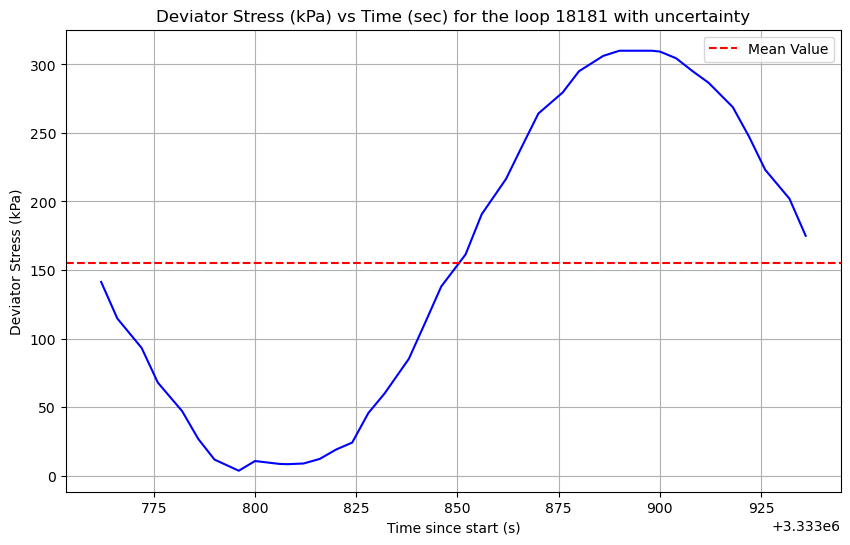

qmax: (3.1+/-0.7)e+02
qmin: 4+/-17
qcyc: 153+/-35
pwp_LCC17: -9.738+/-0.005
delta_pwp_LCC17: -1.623+/-0.008


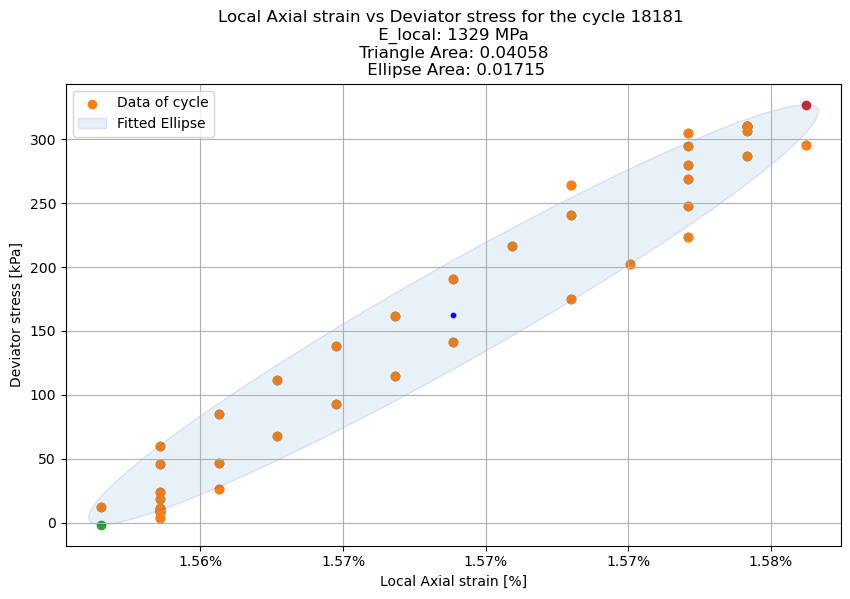

min_x: 0.015565163681284744
max_x: 0.015812229771463866
min_y: -1.5606032328505535
max_y: 326.9052139487576


E_local: 1329.4653950425652 MPa
Relative Uncertainty_E_local: 139.01513794708046 MPa
shear_modulus_mPa: 553.9439146010689

angle 89.99995690314337
prefixed_major_axis_length 328.46581724264985
minor_axis_length 5.850139737938243e-05
Centriod 1.5689+/-0.0017 0.163+/-0.017
width_x 0.00024706609017912176
height_y_MPa 0.32846581718160817

CSR :0.039+/-0.009
qcyc/po :0.49+/-0.12
qcyc/2su :0.078+/-0.018
qm / 2su :0.079+/-0.022

shear_strain :1.8826+/-0.0021
shear_strain :1.8826+/-0.0021


In [104]:

#The loop number i+1: 
i = 18180 #10065 + 10000
f_b = 100

time = cycles_LCC17[i]['Time since start of test (s)']
deviator_stress = cycles_LCC17[i]['Deviator Stress (kPa)']
yerr = cycles_LCC17[i]['Error Deviator Stress (kPa)']

x_values = cycles_LCC17[i]['Local Axial Strain'].tolist()     ## Axial Strain 
y_values = cycles_LCC17[i]['Deviator Stress (kPa)'].tolist()     ## Axial Stress kPa

plt.figure(figsize=(10, 6))
#plt.errorbar(time, deviator_stress, yerr = yerr, fmt='.', linewidth=2, capsize=6) 
plt.plot(time, cycles_LCC17[i]['Deviator Stress (kPa)'], color='blue')
plt.xlabel("Time since start (s)")
plt.ylabel("Deviator Stress (kPa)")
plt.axhline(mean_val_LCC17_P, color='r', linestyle='--', label='Mean Value')
plt.legend()
plt.title(f'Deviator Stress (kPa) vs Time (sec) for the loop {i+1} with uncertainty')
plt.grid(True)
plt.show()


## the cycle amplitude 
qmax = np.max(cycles_LCC17[i]['Deviator Stress & Uncertainty (kPa)'])
qmin = np.min(cycles_LCC17[i]['Deviator Stress & Uncertainty (kPa)'])
qcyc = (qmax - qmin) / 2

print("qmax:", qmax) 
print("qmin:", qmin) 
print("qcyc:", qcyc) 

pwp_LCC17 =  umean(cycles_LCC17[i]['Pore Pressure & Uncertainty (kPa)'])
delta_pwp_LCC17 = umean(cycles_LCC17[i]['Pore Pressure & Uncertainty (kPa)']) - umean(cycles_LCC17[0]['Pore Pressure & Uncertainty (kPa)'])
print("pwp_LCC17:", pwp_LCC17)
print("delta_pwp_LCC17:", delta_pwp_LCC17)


###############
# Filter the outliers in the cycle
#########################################

x_o, y_o, min_x, max_x, min_y, max_y, Cx_l, Cy_l, angle_in_radians, angle_in_degrees, prefixed_major_axis_length = (
Filter_outliers(x_values, y_values, f_b) )

#########################################
# Plot the fit ellipse   #####################
#########################################

# Fit an ellipse model using RANSAC
model = EllipseModel()
points = np.column_stack((x_o, y_o))
model.estimate(points)
center = model.params[0:2]
center_projection_x = center[0]
center_projection_y = center[1]
major_axis_length = model.params[2] * 2
minor_axis_length = model.params[3] * 2
angle = np.degrees(model.params[4])
prefixed_minor_axis_length = minor_axis_length * (prefixed_major_axis_length / major_axis_length )

## The centriod and lateral values with uncertainty 
Error_C_x = abs(Cx_l * Ru_strain_L_LCC17)
Error_C_y = abs(Cy_l * Ru_stress_LCC17)


C_X = ufloat(Cx_l, Error_C_x) * 100  ## △ɛ %
C_Y_MPa = ufloat(Cy_l, Error_C_y) /1000  ## MPa

height_y = abs(max_y - min_y)
height_y_MPa = height_y / 1000     ## MPa
width_x  = abs(max_x - min_x)

E =  height_y_MPa / width_x  ## MPa
E_error = E *  Ru_E_L_LCC17                                                              ####
E_U = ufloat(E, E_error)   

ellipse_area = np.pi * prefixed_major_axis_length * prefixed_minor_axis_length / 4
tri_area = 0.5 * (height_y) * (width_x)
damping_ratio = (1/np.pi) * (ellipse_area/tri_area) 

shear_modulus_mPa = E / (2*(1+v))  ## MPa

shear_strain = (1+v) * C_X  ## %△ϓ = (1+v)△ɛ   Shear strain
shear_stress_mPa = C_Y_MPa / 2    ## △τ = △σ/2   Shear stress

CSR      = qcyc / (2* qf_LCC)
qcyc_po  = qcyc /(Stage_info_LCC17.loc[0]['p_0'])
qcyc_2su = qcyc / (2 * Su_LCC)
qm_2su   = (Stage_info_LCC17.loc[0]['q_m'])/ (2 * Su_LCC)


plt.figure(figsize=(10, 6))            
plt.scatter(x_values, y_values)
plt.scatter(x_o, y_o, label='Data of cycle')
plt.scatter(min_x, min_y)
plt.scatter(max_x, max_y)
plt.scatter(Cx_l, Cy_l, s=10, c='b', marker='o')
ellipse_cstr = Ellipse(xy =(Cx_l, Cy_l), width=prefixed_major_axis_length, height=prefixed_minor_axis_length, angle=angle_in_degrees, edgecolor='b', fill = True, alpha = 0.1, label='Fitted Ellipse')
plt.gca().add_patch(ellipse_cstr)
#plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=100))  # Set max to 100%
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x*100:.2f}%'))  # Format ticks as percentages
plt.xlabel('Local Axial strain [%]')
plt.ylabel('Deviator stress [kPa]')
plt.title(f'Local Axial strain vs Deviator stress for the cycle {i+1} \n E_local: {E:.0f} MPa \n Triangle Area: {tri_area:.5f} \n Ellipse Area: {ellipse_area:.5f}')
plt.grid(True)
plt.legend()
plt.show()

print(f'min_x: {min_x}')
print(f'max_x: {max_x}')
print(f'min_y: {min_y}')
print(f'max_y: {max_y}')
print()
print()
print(f'E_local: {E} MPa')
print(f'Relative Uncertainty_E_local: {E_error} MPa') 
print(f'shear_modulus_mPa: {shear_modulus_mPa}') 
print()
print(f"angle", angle_in_degrees)
print(f"prefixed_major_axis_length", prefixed_major_axis_length)
print(f"minor_axis_length", minor_axis_length)
print(f"Centriod", C_X,C_Y_MPa)
print(f"width_x", width_x)
print(f"height_y_MPa", height_y_MPa)
print()
print(f'CSR :{CSR}')
print(f'qcyc/po :{qcyc_po }')
print(f'qcyc/2su :{qcyc_2su}')
print(f'qm / 2su :{qm_2su  }')
print()
print(f'shear_strain :{shear_strain}')
print(f'shear_strain :{shear_strain }')

### All Cycles

In [27]:
# For each loop, get the start and end times
#plt.figure(figsize=(10, 6))    
f_b = 100

cycle_info_LCC17 = []
for n, loop in enumerate(cycles_LCC17):
  try:
    start_time = loop.iloc[0,2]
    end_time = loop.iloc[-1,2]
        

    x_values = cycles_LCC17[n]['Local Axial Strain'].tolist()     ## Axial Strain 
    y_values = cycles_LCC17[n]['Deviator Stress (kPa)'].tolist()     ## Axial Stress kPa 
    
    ## the cycle amplitude 
    qmax = np.max(cycles_LCC17[n]['Deviator Stress & Uncertainty (kPa)'])
    qmin = np.min(cycles_LCC17[n]['Deviator Stress & Uncertainty (kPa)'])
    qcyc = (qmax - qmin) / 2
    
        
    ## Excess pore water pressure
    pwp =  umean(cycles_LCC17[n]['Pore Pressure & Uncertainty (kPa)'])
    pwp0 = umean(cycles_LCC17[0]['Pore Pressure & Uncertainty (kPa)'])
    delta_pwp = pwp - pwp0
    
    
    ## Loading period T and Frequency of loading f
    Tmax = np.max(cycles_LCC17[n]['Time since start of test (s)'])
    Tmin = np.min(cycles_LCC17[n]['Time since start of test (s)'])  
    T = Tmax - Tmin  
    f = 1 / T
    


    ################################
    # Ellipse calculation    #######
    ################################
    #########################################
        
    ###############
    # Filter the outliers in the cycle
    #########################################
    x_o, y_o, min_x, max_x, min_y, max_y, Cx_l, Cy_l, angle_in_radians, angle_in_degrees, prefixed_major_axis_length = (
    Filter_outliers(x_values, y_values, f_b) )
    
    #########################################
    # Plot the fit ellipse   ################
    #########################################
    
    # Fit an ellipse model using RANSAC
    model = EllipseModel()
    points = np.column_stack((x_o, y_o))
    model.estimate(points)
    center = model.params[0:2]
    center_projection_x = center[0]
    center_projection_y = center[1]
    major_axis_length = model.params[2] * 2
    minor_axis_length = model.params[3] * 2
    angle = np.degrees(model.params[4])
    prefixed_minor_axis_length = minor_axis_length * (prefixed_major_axis_length / major_axis_length )
    
    ## The centriod and lateral values with uncertainty 
    Error_C_x = abs(Cx_l * Ru_strain_L_LCC17)
    Error_C_y = abs(Cy_l * Ru_stress_LCC17)

    
    C_X = ufloat(Cx_l, Error_C_x) * 100  ## △ɛ %
    C_Y_MPa = ufloat(Cy_l, Error_C_y) /1000  ## MPa

    
    height_y = abs(max_y - min_y)
    height_y_MPa = height_y / 1000     ## MPa
    width_x  = abs(max_x - min_x)
    
    E =  height_y_MPa / width_x  ## MPa
    E_error = E *  Ru_E_L_LCC17                                                              ####
    E_U = ufloat(E, E_error)   
    
    ellipse_area = np.pi * prefixed_major_axis_length * prefixed_minor_axis_length / 4
    tri_area = 0.5 * (height_y) * (width_x)
    damping_ratio = (1/np.pi) * (ellipse_area/tri_area) 
    
    shear_modulus_mPa = E / (2*(1+v))  ## MPa
    
    shear_strain = (1+v) * C_X  ## %△ϓ = (1+v)△ɛ   Shear strain
    shear_stress_mPa = C_Y_MPa / 2    ## △τ = △σ/2   Shear stress


    
    CSR      = qcyc / (2* qf_LCC)
    qcyc_po  = qcyc / (Stage_info_LCC17.loc[0]['p_0'])
    qcyc_2su = qcyc / (2 * Su_LCC)
    qm_2su   = Stage_info_LCC17.loc[0]['q_m'] / (2 * Su_LCC)
            
            
    # Append the loop information to the list
    cycle_info_LCC17.append([n+1, start_time, end_time, ellipse_area, tri_area, damping_ratio, C_X, C_Y_MPa, width_x, height_y_MPa, shear_strain, shear_stress_mPa, E, E_error, E_U, shear_modulus_mPa, qmax, qmin, qcyc, pwp, delta_pwp, qm_2su, qcyc_2su, qcyc_po, CSR, T, f])
    
           

    #plt.scatter(Cx_l, Cy_l, s=10, c='r', marker='o', zorder=2)
    #ellipse_cstr = Ellipse(xy =(Cx_l, Cy_l), width=prefixed_major_axis_length, height=prefixed_minor_axis_length, angle=angle_in_degrees, edgecolor='b', fill = False, label='Fitted Ellipse', zorder=1)
    #plt.gca().add_patch(ellipse_cstr)
    
  except Exception as e:  # Catch any exceptions during processing
   print(f"Error encountered for loop {n}: {e}")
   pass  # Continue to the next loop iteration 
    
#plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x*100:.2f}%'))  # Format ticks as percentages   
#plt.xlabel('Axial strain [%]')
#plt.ylabel('Axial stress [kPa]')
#plt.title(f"Local - Axial strain [%] vs Axial stress [kPa] for {n+1} loops - sample LCC17")
#plt.grid(True)
#plt.show()      
     

# Convert loop_info to a DataFrame
cycle_info_LCC17_L = pd.DataFrame(cycle_info_LCC17, columns=['Loop_Number', 'Start_Time', 'End_Time', 'Ellipse_area', 'Triangle_area', 'Damping_ratio', 'C_X(%)', 'C_Y(MPa)', 'Delta_x', 'Delta_y(MPa)', 'Shear Strain', 'Shear Stress(MPa)', 'E(MPa)', 'E_error', 'E_U(MPa)', 'Shear_modulus_(MPa)', 'qmax', 'qmin', 'qcyc', 'pwp', 'delta_pwp', 'qm/2su', 'qcyc/2su', 'qcyc/po', 'CSR', 'T_(s)', 'f(Hz)'])

# Split the DataFrame into two parts
split_index = 10065
cycle_info_LCC17_L_1 = cycle_info_LCC17_L.iloc[:split_index]
cycle_info_LCC17_L_2 = cycle_info_LCC17_L.iloc[split_index:]


Path_cycle_info_LCC17_L = os.path.join('Outputs_csv', 'cycle_info_LCC17_L.csv')
cycle_info_LCC17_L.to_csv(Path_cycle_info_LCC17_L, index=False)

cycle_info_LCC17_L_2


,Loop_Number,Start_Time,End_Time,Ellipse_area,Triangle_area,Damping_ratio,C_X(%),C_Y(MPa),Delta_x,Delta_y(MPa),...,qmin,qcyc,pwp,delta_pwp,qm/2su,qcyc/2su,qcyc/po,CSR,T_(s),f(Hz)
10065,10066,1873152,1873326,0.014421,0.035567,0.129058,1.5658+/-0.0017,0.152+/-0.016,0.000226,0.314091,...,12+/-17,(1.5+/-0.4)e+02,-9.416+/-0.006,-1.301+/-0.009,0.079+/-0.022,0.076+/-0.018,0.48+/-0.12,0.038+/-0.009,174,0.005747
10066,10067,1873332,1873508,0.012669,0.028690,0.140563,1.5668+/-0.0017,0.160+/-0.017,0.000206,0.278697,...,11+/-17,(1.5+/-0.4)e+02,-9.329+/-0.006,-1.214+/-0.009,0.079+/-0.022,0.076+/-0.018,0.48+/-0.12,0.038+/-0.009,176,0.005682
10067,10068,1873512,1873684,0.012648,0.028844,0.139577,1.5668+/-0.0017,0.157+/-0.016,0.000206,0.280190,...,11+/-17,(1.5+/-0.4)e+02,-9.308+/-0.006,-1.193+/-0.009,0.079+/-0.022,0.076+/-0.018,0.48+/-0.12,0.038+/-0.009,172,0.005814
10068,10069,1873690,1873870,0.014399,0.029313,0.156357,1.5668+/-0.0017,0.154+/-0.016,0.000206,0.284748,...,11+/-17,(1.5+/-0.4)e+02,-9.307+/-0.005,-1.193+/-0.009,0.079+/-0.022,0.076+/-0.018,0.48+/-0.12,0.038+/-0.009,180,0.005556
10069,10070,1873876,1874046,0.011179,0.029224,0.121767,1.5668+/-0.0017,0.157+/-0.016,0.000206,0.283880,...,11+/-17,(1.5+/-0.4)e+02,-9.175+/-0.006,-1.061+/-0.009,0.079+/-0.022,0.076+/-0.018,0.48+/-0.12,0.038+/-0.009,170,0.005882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20254,20255,3707082,3707256,0.012132,0.028776,0.134198,1.5689+/-0.0017,0.148+/-0.015,0.000206,0.279533,...,4+/-17,153+/-35,-7.543+/-0.005,0.572+/-0.008,0.079+/-0.022,0.078+/-0.018,0.49+/-0.12,0.039+/-0.009,174,0.005747
20255,20256,3707262,3707436,0.012786,0.033992,0.119732,1.5699+/-0.0017,0.158+/-0.017,0.000226,0.300183,...,8+/-17,151+/-35,-7.503+/-0.004,0.612+/-0.008,0.079+/-0.022,0.077+/-0.018,0.49+/-0.12,0.039+/-0.009,174,0.005747
20256,20257,3707442,3707622,0.011947,0.033738,0.112718,1.5699+/-0.0017,0.154+/-0.016,0.000226,0.297940,...,2+/-16,154+/-35,-7.585+/-0.005,0.530+/-0.008,0.079+/-0.022,0.079+/-0.018,0.50+/-0.12,0.039+/-0.009,180,0.005556
20257,20258,3707626,3707796,0.011869,0.034564,0.109308,1.5699+/-0.0017,0.155+/-0.016,0.000226,0.305230,...,3+/-17,153+/-35,-7.555+/-0.005,0.560+/-0.008,0.079+/-0.022,0.078+/-0.018,0.49+/-0.12,0.039+/-0.009,170,0.005882


## Max & Min error in E

In [18]:
E_max = np.max(cycle_info_LCC17_L['E(MPa)'])
print(f'max E : {E_max}')     
E_min = np.min(cycle_info_LCC17_L['E(MPa)'])
print(f'min E : {E_min}')

max E : 2607.9411837013276
min E : 1183.0236091096062


In [19]:
E_Error_max = np.max(cycle_info_LCC17_L['E_error'])
print(f'max error : {E_Error_max}')
E_Error_min = np.min(cycle_info_LCC17_L['E_error'])
print(f'min error : {E_Error_min}')


max error : 272.69856346919426
min error : 123.70249788243603


## The cycle number which has largest error

In [20]:
# Find index where 'Ru_E_global(%)' equals 11120.814809156738
index = np.where(cycle_info_LCC17_L['E_error'] == np.max(cycle_info_LCC17_L['E_error']))[0]
print(f"The index where 'E_error' equals  is {index}.")

The index where 'E_error' equals  is [7489].


## The cycle numbers which has largest of value of error


In [21]:
index = cycle_info_LCC17_L[cycle_info_LCC17_L['E_error'] >= 250].index
print(len(index))
print(f"The index where 'Ru_E_local(%)' is greater than or equal to n is: {index.tolist()}")


26
The index where 'Ru_E_local(%)' is greater than or equal to n is: [6036, 6283, 6596, 6753, 6846, 7386, 7423, 7489, 7612, 8112, 8213, 8281, 8413, 8433, 8435, 8452, 8571, 8572, 8805, 8844, 8943, 9962, 9966, 10064, 12184, 15871]


#####################################################################################################
#######################################################################################################
######################################################################################################